 ## **1.Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
warnings.filterwarnings('ignore')


##**2.Load Dataset**

In [3]:
df = pd.read_csv('/content/Copy of bankruptcy-prevention.csv')

In [4]:
df.columns = df.columns.str.strip()  # Strip whitespace from column names
df['class'] = df['class'].map({'non-bankruptcy': 0, 'bankruptcy': 1})

code  preprocesses a dataframe: it trims whitespace from column names and encodes the target label by mapping the 'class' column from strings to binary integers, converting 'non-bankruptcy' to 0 and 'bankruptcy' to 1.

##**3.Dataset Details**

In [5]:
df.head()

industrial_risk  management_risk  financial_flexibility  credibility  \
0              0.5              1.0                    0.0          0.0   
1              0.0              1.0                    0.0          0.0   
2              1.0              0.0                    0.0          0.0   
3              0.5              0.0                    0.0          0.5   
4              1.0              1.0                    0.0          0.0   

   competitiveness  operating_risk  class  
0              0.0             0.5      1  
1              0.0             1.0      1  
2              0.0             1.0      1  
3              0.0             1.0      1  
4              0.0             1.0      1

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   industrial_risk         250 non-null    float64
 1    management_risk        250 non-null    float64
 2    financial_flexibility  250 non-null    float64
 3    credibility            250 non-null    float64
 4    competitiveness        250 non-null    float64
 5    operating_risk         250 non-null    float64
 6    class                  250 non-null    object 
dtypes: float64(6), object(1)
memory usage: 13.8+ KB


summary of the DataFrame’s structure, including the index range, column names, data types, non-null counts, and memory usage.

In [ ]:
df.describe()

industrial_risk   management_risk   financial_flexibility  \
count       250.000000        250.000000              250.000000   
mean          0.518000          0.614000                0.376000   
std           0.411526          0.410705                0.401583   
min           0.000000          0.000000                0.000000   
25%           0.000000          0.500000                0.000000   
50%           0.500000          0.500000                0.500000   
75%           1.000000          1.000000                0.500000   
max           1.000000          1.000000                1.000000   

        credibility   competitiveness   operating_risk  
count    250.000000        250.000000       250.000000  
mean       0.470000          0.476000         0.570000  
std        0.415682          0.440682         0.434575  
min        0.000000          0.000000         0.000000  
25%        0.000000          0.000000         0.000000  
50%        0.500000          0.500000         0.500000  
75%        1.000000          1.000000         1.000000  
max        1.000000          1.000000         1.000000

 generates summary statistics (such as count, mean, standard deviation, min, max, and quartiles) for numeric columns in the dataframe.

In [ ]:
df.isnull().sum()

industrial_risk          0
management_risk          0
financial_flexibility    0
credibility              0
competitiveness          0
operating_risk           0
class                    0
dtype: int64

computes the count of missing values for each column by summing the boolean null indicators, yielding a per-column tally of absent data.

In [ ]:
df.duplicated().sum()

np.int64(147)

which identifies duplicate rows and then sums the resulting boolean indicators to produce the total number of duplicate entries in the dataset.



In [ ]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [ ]:
df['class'].value_counts()

class
0    78
1    25
Name: count, dtype: int64

Computes the frequency of each unique value in the 'class' column, typically returning counts for categories such as '0' and '1' (or their mapped equivalents) to show the distribution of classes in the dataset.

In [ ]:
#Detect outliers
numeric_cols = df.select_dtypes(include='number').columns
for col in numeric_cols:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower = Q1 - 1.5 * IQR
  upper = Q3 + 1.5 * IQR

  outliers = df[(df[col] < lower) | (df[col] > upper)]
  print(f"{col}: {len(outliers)} outliers")

industrial_risk: 0 outliers
management_risk: 0 outliers
financial_flexibility: 0 outliers
credibility: 0 outliers
competitiveness: 0 outliers
operating_risk: 0 outliers
class: 25 outliers


 procedure to detect outliers in numeric columns of a dataframe. It selects all numeric columns, computes the first and third quartiles (Q1 and Q3) to determine the interquartile range (IQR), defines lower and upper bounds as Q1 − 1.5·IQR and Q3 + 1.5·IQR, identifies outliers outside these bounds for each column, and prints the count of outliers per numeric column.

In [ ]:
#full descriptive statistics
summary = df.describe()
summary = summary.loc[['mean', 'std']]
numeric_cols = df.select_dtypes(include=np.number)
summary.loc['median'] = numeric_cols.median()
summary.loc['IQR'] = numeric_cols.quantile(0.75) - numeric_cols.quantile(0.25)
print(summary)

        industrial_risk  management_risk  financial_flexibility  credibility  \
mean           0.485437         0.563107               0.504854     0.582524   
std            0.404971         0.412308               0.405206     0.377668   
median         0.500000         0.500000               0.500000     0.500000   
IQR            1.000000         1.000000               1.000000     0.500000   

        competitiveness  operating_risk     class  
mean           0.640777        0.514563  0.242718  
std            0.410747        0.439788  0.430823  
median         1.000000        0.500000  0.000000  
IQR            0.500000        1.000000  0.000000  


it computes the full descriptive statistics with df.describe(), then narrows it to the mean and standard deviation, refines the set of numeric columns using select_dtypes(include=np.number), adds a row for medians using the numeric columns’ median, computes an IQR row as the difference between the 75th and 25th percentiles, and prints the resulting summary.

##**4.Exploratory Data Analysis (EDA)**

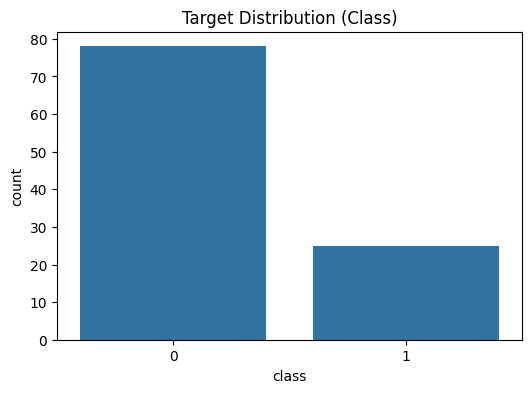

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='class')
plt.title("Target Distribution (Class)")
plt.show()

The count plot shows the distribution of the target variable 'class'. The bar on the left represents the number of instances in class '0' (non-bankruptcy), and the bar on the right represents the number of instances in class '1' (bankruptcy). It clearly shows that there are significantly more instances of non-bankruptcy than bankruptcy in the dataset.

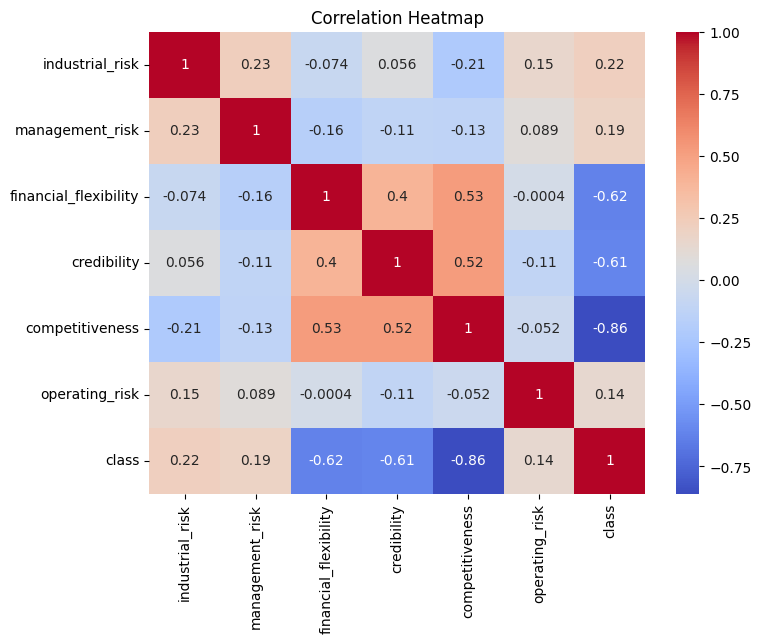

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(8,6))
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

The correlation heatmap visualizes the pairwise correlations between the numeric features in the dataset. The color intensity and the numbers in each cell indicate the strength and direction of the correlation between two features. Red colors generally indicate positive correlation, while blue colors indicate negative correlation. The diagonal line shows the correlation of a feature with itself, which is always 1.

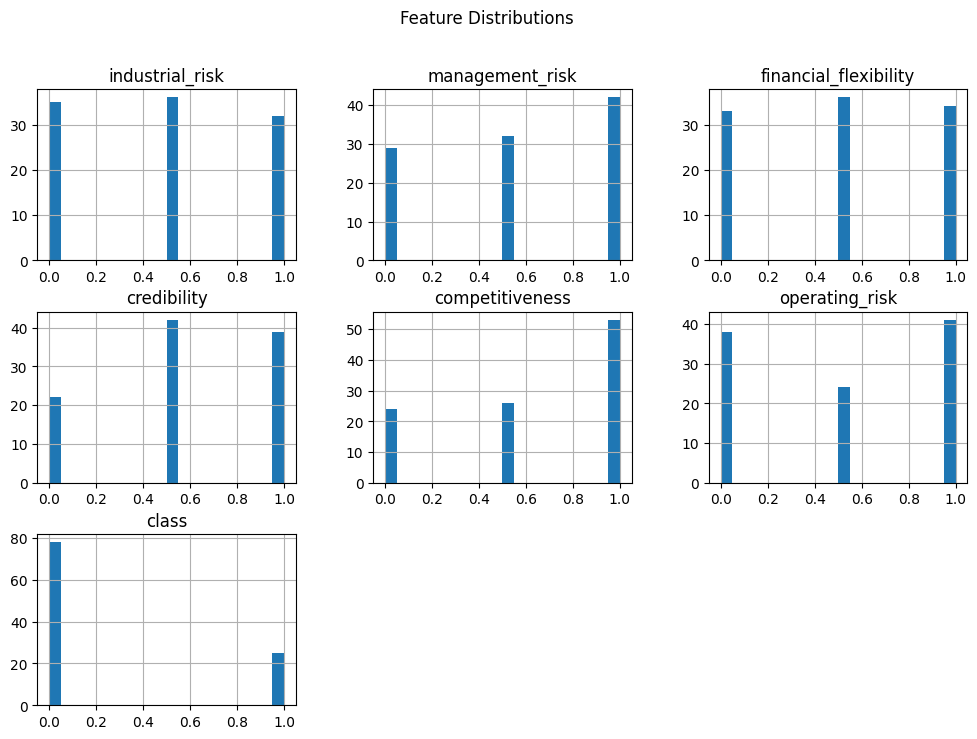

In [ ]:
# Feature Distribution
df.hist(bins=20, figsize=(12,8))
plt.suptitle("Feature Distributions")
plt.show()

The feature distribution plots are histograms for each numeric feature in the dataset. Each histogram shows how frequently different values appear within that feature. This helps visualize the spread and shape of the data for each characteristic.

##**5.Feature Engineering**

In [ ]:
# Feature Names
feature_names = ['industrial_risk', 'management_risk',
                 'financial_flexibility', 'credibility',
                 'competitiveness', 'operating_risk']

X = df[feature_names]
y = df['class']


 it lists six feature names—industrial_risk, management_risk, financial_flexibility, credibility, competitiveness, and operating_risk—and constructs the feature matrix X by selecting these columns from df, while setting the target variable y to the 'class' column.



**Standard Scaler**

In [ ]:
# Standard Scaler (only for models needing it)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

it initializes a StandardScaler, fits it to X, and transforms X to produce X_scaled for models that require standardized features.

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


 The data is split into training and testing sets.

##**6.Model Building**

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier()
}

results = {}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = (clf, acc)
    print(f"{name} Accuracy: {acc:.3f}")


Logistic Regression Accuracy: 0.952
Decision Tree Accuracy: 0.952
Random Forest Accuracy: 0.952
SVM Accuracy: 0.952
KNN Accuracy: 1.000


evaluating their performance on a train/test split. Each model is trained on the training data (X_train, y_train), makes predictions on the test set (X_test), and its accuracy is computed against the true labels (y_test). The results dictionary stores, for each model, the trained classifier and its accuracy, and the code prints each model’s accuracy.

Building ANN model

In [ ]:
!pip install scikeras

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
#ANN Model

def create_ann():
    model = Sequential()
    model.add(Dense(8, input_dim=len(feature_names), activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

ann = KerasClassifier(model=create_ann, epochs=100, batch_size=16, verbose=0)
ann.fit(X_train, y_train)
ann_acc = accuracy_score(y_test, np.round(ann.predict(X_test)))
results["ANN"] = (ann, ann_acc)
# Print the accuracy of the ANN model
print("ANN Model Accuracy:", ann_acc)


ANN Model Accuracy: 0.9523809523809523


training an artificial neural network (ANN) using Keras via the Scikeras wrapper. It builds a Sequential model with an input layer matching the feature count, two hidden layers (8 and 4 neurons with ReLU), and a sigmoid output for binary classification. The model uses binary cross-entropy loss, Adam optimizer, and accuracy as a metric, wrapped by KerasClassifier and trained for 100 epochs with a 16-item batch size. It evaluates on the test set by predicting and thresholding, stores the result in results["ANN"], and prints the ANN accuracy.

##**7.Model Evaluation**


Model Evaluation Report:

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.80      0.89         5

    accuracy                           0.95        21
   macro avg       0.97      0.90      0.93        21
weighted avg       0.96      0.95      0.95        21


--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.80      0.89         5

    accuracy                           0.95        21
   macro avg       0.97      0.90      0.93        21
weighted avg       0.96      0.95      0.95        21


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.80      0.89         5

    accuracy                           0.95        21
   macro avg       0.97    

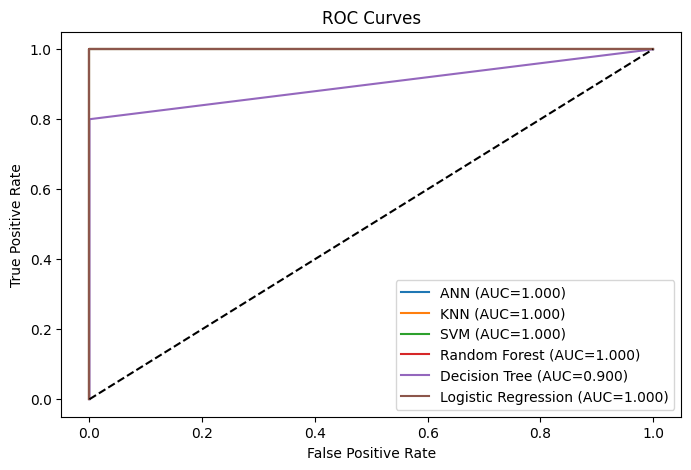

In [ ]:
print("\nModel Evaluation Report:")
for name, (model, acc) in results.items():
    print(f"\n--- {name} ---")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

# Model Evaluation with ROC Curve
plt.figure(figsize=(8,5))
for name, (model, _) in reversed(list(results.items())):
    if name != "ANN":
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        y_proba = ann.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()



The classification report for each model includes key metrics like precision, recall, and F1-score, which give insights into the model's accuracy in classifying both bankruptcy (class 1) and non-bankruptcy (class 0) cases.

The confusion matrix visually summarizes the predictions by showing the counts of true positives, true negatives, false positives, and false negatives.

The ROC curves and AUC scores help in understanding the trade-off between the true positive rate and false positive rate at various classification thresholds. A higher AUC score indicates better overall model performance.

##**8.Hyperparameter Tuning**

In [ ]:
# Hyperparameter Tuning (Example: Random Forest)

param_grid = {
    "n_estimators": [50,100,200],
    "max_depth": [3,5, None]
}
gscv = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid,
                    cv=3,
                    scoring="accuracy",
                    verbose=0)
gscv.fit(X_train, y_train)
print("\nBest Random Forest Params:", gscv.best_params_)



Best Random Forest Params: {'max_depth': 3, 'n_estimators': 50}


finds the best combination of parameters for a machine learning model to optimize its performance. In this notebook, we performed hyperparameter tuning on the Random Forest model using GridSearchCV.

##**9.Coefficient Interpretation**

In [ ]:
# Coefficient Interpretation (Logistic Regression only)

log_reg_model = models["Logistic Regression"]
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": log_reg_model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

print("\nLogistic Regression Coefficients:")
print(coef_df)



Logistic Regression Coefficients:
                 Feature  Coefficient
0        industrial_risk     0.568898
1        management_risk     0.170268
5         operating_risk     0.094818
3            credibility    -0.780112
2  financial_flexibility    -0.955703
4        competitiveness    -2.346316


The coefficient interpretation section focuses on the Logistic Regression model because it's a linear model where the coefficients directly indicate the impact of each feature on the log-odds of the target variable.

* Positive coefficients (e.g., industrial_risk, management_risk, operating_risk) suggest that as the value of that feature increases, the likelihood of bankruptcy increases (holding other features constant).
* Negative coefficients (e.g., credibility, financial_flexibility, competitiveness) suggest that as the value of that feature increases, the likelihood of bankruptcy decreases (holding other features constant).

The magnitude of the coefficient indicates the strength of the relationship. For example, competitiveness has the largest negative coefficient (-2.346316), suggesting it has the strongest negative impact on the likelihood of bankruptcy among these features.

##**10.Best Model and Save**

In [ ]:
# Select Best Model

best_model_name = max(results, key=lambda x: results[x][1])
best_model, best_acc = results[best_model_name]

print(f"\nBest Model: {best_model_name}, Test Accuracy: {best_acc:.2f}")


Best Model: KNN, Test Accuracy: 1.00


Save  Best Model

In [ ]:
#Select Best Model

if best_model_name != "ANN":
    joblib.dump((best_model, scaler, feature_names), 'bankruptcy_model.pkl')
else:
    ann.model_.save('bankruptcy_ann_model.h5')
    joblib.dump((scaler, feature_names), 'ann_feature_names.pkl')